In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import seaborn as sns
import librosa
from librosa import display
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.utils import plot_model
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

import random

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

2025-06-17 08:20:21.539299: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750128621.550424   26693 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750128621.553914   26693 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-17 08:20:21.565726: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Normalized features

In [2]:


# Define the path to your dataset
dataset_path = "/home/muzaffar/Desktop/Research/papers/02-paperhybrid-word-spken-paper(ablation)/10-words/original-data-3630"

# Initialize lists to hold features and labels
feature_list = []
label_list = []

# Define a function to normalize the mel spectrogram
def normalize_mel_spectrogram(mel_spectrogram):
    mel_spectrogram_db = librosa.power_to_db(S=mel_spectrogram, ref=1.0)
    return (mel_spectrogram_db - np.mean(mel_spectrogram_db)) / np.std(mel_spectrogram_db)

# Define a fixed size for padding (e.g., 128 time steps)
fixed_size = 32

# Update the feature extraction process
for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)

    for file in tqdm(os.listdir(class_path)):
        if not file.endswith('.wav'):
            continue

        audio_path = os.path.join(class_path, file)
        audio, sr = librosa.load(path=audio_path, sr=None)
        
        # Avoid using time_stretch unless intended
        # audio = librosa.effects.time_stretch(y=audio, rate=len(audio)/sr)

        mels = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=2048, hop_length=512)
        normalized_mels = normalize_mel_spectrogram(mels)

        # Pad or truncate to fixed size
        if normalized_mels.shape[1] < fixed_size:
            # Pad with zeros
            pad_width = fixed_size - normalized_mels.shape[1]
            padded_mels = np.pad(normalized_mels, ((0, 0), (0, pad_width)), mode='constant')
        else:
            # Truncate to fixed size
            padded_mels = normalized_mels[:, :fixed_size]

        feature_list.append(padded_mels.T)
        label_list.append(class_folder)

# Convert to NumPy arrays
features = np.array(feature_list)
labels = np.array(label_list)

print("Feature shape:", features.shape)
print("Label shape:", labels.shape)


100%|██████████| 364/364 [00:01<00:00, 348.84it/s]

Feature shape: (3630, 32, 128)
Label shape: (3630,)


In [4]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Set parameters for data splitting and training
TEST_SIZE = 0.2
RANDOM_STATE = 42  # For reproducibility

# Encode Labels (from strings to integers)
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(labels)

# One-hot encode the integer labels
encoded_labels = tf.one_hot(indices=integer_labels, depth=len(label_encoder.classes_))

from sklearn.model_selection import train_test_split

# Perform stratified split
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    encoded_labels.numpy(), 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE, 
    stratify=integer_labels  # Stratify ensures balanced splits for each class
)


print("Train, validation, and test data prepared successfully.")


Train, validation, and test data prepared successfully.


In [5]:
features[1].shape

(32, 128)

In [6]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# Flatten (32, 128) features → (4096,)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Convert one-hot labels back to integers
y_train_int = np.argmax(y_train, axis=1)
y_test_int = np.argmax(y_test, axis=1)

# Create and train the SVM model
svm_model = SVC(kernel='rbf', C=10, gamma='scale')  # Try 'linear', 'poly', 'rbf'
svm_model.fit(X_train_flat, y_train_int)

# Make predictions
y_pred = svm_model.predict(X_test_flat)

# Evaluate the model
print("✅ SVM Accuracy:", accuracy_score(y_test_int, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test_int, y_pred))
print("\n🧩 Confusion Matrix:\n", confusion_matrix(y_test_int, y_pred))


✅ SVM Accuracy: 0.8085399449035813

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.81      0.81        72
           1       0.75      0.83      0.79        72
           2       0.67      0.75      0.71        73
           3       0.78      0.81      0.79        73
           4       0.85      0.78      0.81        73
           5       0.80      0.78      0.79        72
           6       0.90      0.86      0.88        73
           7       0.91      0.88      0.90        73
           8       0.79      0.83      0.81        72
           9       0.87      0.75      0.81        73

    accuracy                           0.81       726
   macro avg       0.81      0.81      0.81       726
weighted avg       0.81      0.81      0.81       726


🧩 Confusion Matrix:
 [[58  3  2  2  5  1  0  1  0  0]
 [ 3 60  1  5  0  1  0  0  1  1]
 [ 4  3 55  1  3  0  0  1  5  1]
 [ 1  7  4 59  0  0  0  0  2  0]
 [ 1  0  8  3 57  0  0  0

📋 SVM Classification Report:
              precision    recall  f1-score   support

         Akh       0.81      0.81      0.81        72
         Zie       0.75      0.83      0.79        72
       Thrre       0.67      0.75      0.71        73
        Tsor       0.78      0.81      0.79        73
       Pancs       0.85      0.78      0.81        73
        Shae       0.80      0.78      0.79        72
        Sath       0.90      0.86      0.88        73
      Eahght       0.91      0.88      0.90        73
         Nav       0.79      0.83      0.81        72
        Daah       0.87      0.75      0.81        73

    accuracy                           0.81       726
   macro avg       0.81      0.81      0.81       726
weighted avg       0.81      0.81      0.81       726



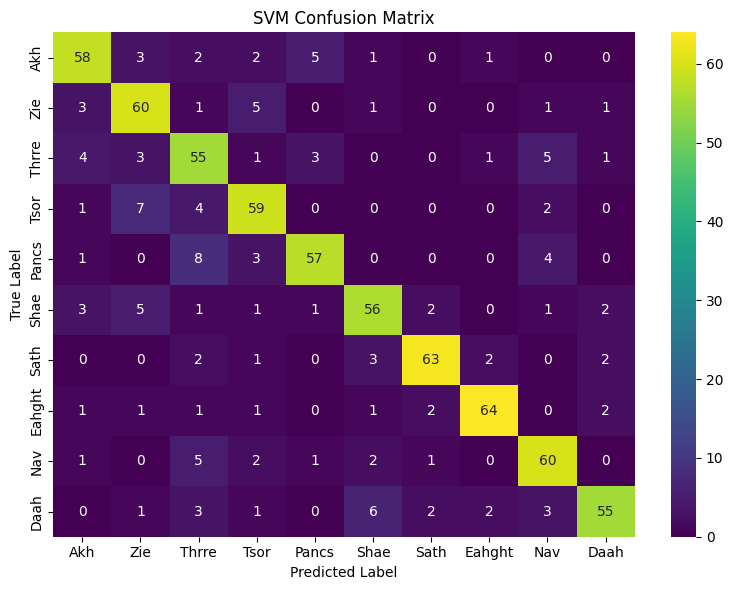

In [7]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Already predicted using SVM
# y_pred = svm_model.predict(X_test_flat)
# y_test_int = np.argmax(y_test, axis=1)

# Step 2: Classification Report
print("📋 SVM Classification Report:")
print(classification_report(y_test_int, y_pred, target_names=['Akh', 'Zie', 'Thrre', 'Tsor', 'Pancs', 'Shae', 'Sath', 'Eahght', 'Nav', 'Daah']))

# Step 3: Confusion Matrix
conf_matrix = confusion_matrix(y_test_int, y_pred, labels=range(10))

# Step 4: Plot Confusion Matrix
plt.figure(figsize=(8, 6))
custom_ticks = ['Akh', 'Zie', 'Thrre', 'Tsor', 'Pancs', "Shae", "Sath", "Eahght", "Nav", "Daah"]
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=custom_ticks, yticklabels=custom_ticks)
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


In [10]:
y_pred_svm = svm_model.predict(X_test_flat)

# Step 1: Overall Accuracy for SVM
overall_accuracy_svm = accuracy_score(y_test_int, y_pred_svm)
print(f"\n✅ SVM Model Overall Accuracy: {overall_accuracy_svm:.4f}")

# Step 2: Classification report for SVM
report_svm = classification_report(y_test_int, y_pred_svm, target_names=custom_ticks, output_dict=True)

# Step 3: Print metrics for each class
for class_name in custom_ticks:
    print(f"\n📊 Metrics for class '{class_name}' (SVM Model):")
    print(f"Precision: {report_svm[class_name]['precision']:.4f}")
    print(f"Recall: {report_svm[class_name]['recall']:.4f}")
    print(f"F1-Score: {report_svm[class_name]['f1-score']:.4f}")
    print(f"Support: {report_svm[class_name]['support']}")



✅ SVM Model Overall Accuracy: 0.8085

📊 Metrics for class 'Akh' (SVM Model):
Precision: 0.8056
Recall: 0.8056
F1-Score: 0.8056
Support: 72.0

📊 Metrics for class 'Zie' (SVM Model):
Precision: 0.7500
Recall: 0.8333
F1-Score: 0.7895
Support: 72.0

📊 Metrics for class 'Thrre' (SVM Model):
Precision: 0.6707
Recall: 0.7534
F1-Score: 0.7097
Support: 73.0

📊 Metrics for class 'Tsor' (SVM Model):
Precision: 0.7763
Recall: 0.8082
F1-Score: 0.7919
Support: 73.0

📊 Metrics for class 'Pancs' (SVM Model):
Precision: 0.8507
Recall: 0.7808
F1-Score: 0.8143
Support: 73.0

📊 Metrics for class 'Shae' (SVM Model):
Precision: 0.8000
Recall: 0.7778
F1-Score: 0.7887
Support: 72.0

📊 Metrics for class 'Sath' (SVM Model):
Precision: 0.9000
Recall: 0.8630
F1-Score: 0.8811
Support: 73.0

📊 Metrics for class 'Eahght' (SVM Model):
Precision: 0.9143
Recall: 0.8767
F1-Score: 0.8951
Support: 73.0

📊 Metrics for class 'Nav' (SVM Model):
Precision: 0.7895
Recall: 0.8333
F1-Score: 0.8108
Support: 72.0

📊 Metrics for c